<a href="https://colab.research.google.com/github/goya5858/OSERO/blob/main/Othello_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import torch.multiprocessing as mp
import time

import copy

import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gym
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import functional as F

In [2]:
# 対戦相手
# 置ける場所にランダムに置いていく

class Random_Player:
    def __init__(self):
        pass
    
    def get_action(self, board):
        puttables = self.check(board) #print("CPU puttables", puttables)
        action = random.choice(puttables) #print("CPUs action", action)
        action = 8 * action[0] + action[1]
        return action
    
    def check(self, board): #今回の手番の人が打てる場所をリストアップする
        okeru_list = []
        for x in range(8):
            for y in range(8):
                plc = board[y, x]
                if plc == 0: #もし今回のplaceに何も置いていなければ8方向探索する
                    able = self.octpass([x,y], board) #今回の場所に置いたときひっくり返せる場所をリストアップする
                    if len(able) > 0: #もしひっくり返せる場所が0ではないなら置ける場所リストに今回の場所を追加する
                        okeru_list.append([x,y])
        return okeru_list
    
    def octpass(self, basho, board): #今回置きたい場所を渡したら８方向探索するメソッド
        basho_list = set() #今回ひっくり返せる場所のリスト(setクラスを使う→重複なしで扱える)

        if board[basho[1], basho[0]] != 0:
            pass #print('既に石が置かれています')
        else:
            for x in [-1,0,1]:
                for y in [-1,0,1]: #8方向を順に見ていく
                    tmp = [] #今回の確認する方向でひっくり返そうな場所を一時的に記憶しておくリスト

                    if x == 0 and y == 0:
                        pass #方向がないときはパスする

                    for length in range(1,9): #今回確認する方向にだんだん腕を伸ばしていく
                        if 0<=basho[1]+y*length<=7 and 0<=basho[0]+x*length<=7: #腕が盤面に収まるのなら
                            check_plc = board[basho[1]+y*length, basho[0]+x*length]
                            if check_plc == 0: #もし確認した場所に何も置いていなければ、飛び石になっちゃうので手を伸ばすのを終了
                                break
                            elif check_plc == -1: #もし確認した場所が相手プレイヤーの石だった場合その場所を一時記憶しておく
                                tmp.append( (basho[0]+x*length, basho[1]+y*length) )
                            elif check_plc == 1: #もし確認した場所が自分の石だった場合、ひっくり返せるリストに現在ひっくり返せそうな場所を追加して腕を伸ばすのをやめる
                                if len(tmp) > 0: #中身がからでない場合のみ
                                    basho_list |= set(tmp)
                                break #手を伸ばすのを終了

                        else: #もし盤面を飛び出してしまうならpassする
                            pass
        return list(basho_list)

In [3]:
# オセロ自体のクラス
# 盤面を持っており、石をおくとひっくり返す
# もしすでに置いてある場所や不適切な場所に置いた場合、空のリストを返す

class OTHELLO:
    def __init__(self, player_color='B'):
        self.player = player_color

        # 差し手の色が1, 相手(CPU)の色が-1
        self.board = np.zeros((8,8)).astype(np.int8)
        self.board[3,4] = self.board[4,3] = -1
        self.board[3,3] = self.board[4,4] = 1
        if self.player == 'W': #もし差し手が白なら1, -1を反転する
            self.board *= -1
    
    def put(self, basho, player='human'):
        # 石をおいてひっくり返す     basho = (x, y) の形式

        if self.board[ basho[1], basho[0] ] != 0:
            return [] #print('すでにおいてあります')
 
        if player != 'human':
            self.board*=-1 # もし差し手がCPUの場合、敵味方のラベルを入れ替える

        reversibles = self.octpass(basho)
        if reversibles:
            #空でないなら
            self.board[basho[1], basho[0]] = 1
            for reversible_basho in reversibles:
                self.board[reversible_basho[1], reversible_basho[0]] = 1
            if player != 'human':
                self.board*=-1 # もし差し手がCPUの場合、敵味方のラベルを入れ替え直す
            return self.board

        else: # もしひっくり返せる場所においてなかった場合
            if player != 'human':
                self.board*=-1 # もし差し手がCPUの場合、敵味方のラベルを入れ替え直す
            return []
        
          
    def check(self, player='human'):
        # 盤面を渡すと、今回置ける場所を返してくれる
        # 0が置いてない場所、1が自分の意思がある場所、-1が相手の石が置いてある場所
        okeru_list = []
        if player != 'human':
            self.board*=-1
        for x in range(8):
            for y in range(8):
                plc = self.board[y, x]
                if plc == 0: #もし今回のplaceに何も置いていなければ8方向探索する
                    able = self.octpass([x,y]) #今回の場所に置いたときひっくり返せる場所をリストアップする
                    if len(able) > 0: #もしひっくり返せる場所が0ではないなら置ける場所リストに今回の場所を追加する
                        okeru_list.append([x,y])
        if player != 'human':
            self.board*=-1
        return okeru_list
    
    def find(self):
        # 自分(1)が置ける場所を"5"で示す (相手の石の場所は-1)　
        places = self.check()
        cm_board = copy.deepcopy( self.board )
        for basho in places:
            cm_board[basho[1], basho[0]] = 5
        print(cm_board)
  
    def octpass(self, basho): 
        # 今回置きたい場所を渡したら８方向探索するメソッド
        # 今回ひっくり返せる場所が帰ってくる
        basho_list = set() #今回ひっくり返せる場所のリスト(setクラスを使う→重複なしで扱える)

        if self.board[basho[1], basho[0]] != 0:
            #print('既に石が置かれています')
            pass
        else:
            for x in [-1,0,1]:
                for y in [-1,0,1]: #8方向を順に見ていく
                    tmp = [] #今回の確認する方向でひっくり返そうな場所を一時的に記憶しておくリスト

                    if x == 0 and y == 0:
                        pass #方向がないときはパスする

                    for length in range(1,9): #今回確認する方向にだんだん腕を伸ばしていく
                        if 0<=basho[1]+y*length<=7 and 0<=basho[0]+x*length<=7: #腕が盤面に収まるのなら
                            check_plc = self.board[ basho[1]+y*length, basho[0]+x*length ]
                            if check_plc == 0: #もし確認した場所に何も置いていなければ、飛び石になっちゃうので手を伸ばすのを終了
                                break
                            elif check_plc == -1: #もし確認した場所が相手プレイヤーの石だった場合その場所を一時記憶しておく
                                tmp.append( (basho[0]+x*length, basho[1]+y*length) )
                            elif check_plc == 1: #もし確認した場所が自分の石だった場合、ひっくり返せるリストに現在ひっくり返せそうな場所を追加して腕を伸ばすのをやめる
                                if len(tmp) > 0: #中身がからでない場合のみ
                                    basho_list |= set(tmp)
                                break #手を伸ばすのを終了

                        else: #もし盤面を飛び出してしまうならpassする
                            pass
        return list(basho_list)

In [4]:
# オセロを実行するタスク本体
# オセロゲーム自体と、対戦相手(CPU)を持つ

# Instance.reset() メソッドで初期化
# state_next, reward, done, info = Instance.step( action )
# 上記のようにcart poleのように使える
# infoは形だけ　中身は相手が打てる手があるかの判断として使ってる 

# Human-Playerが先手の場合、player_color='B'
# Human-Playerが後手の場合、player_color='W'
# で設定する

class OTHELLO_Task:
    def __init__(self, player_color='B', view_board=False):
        self.player_color = player_color
        self.GAME = OTHELLO(player_color=self.player_color)
        self.CPU_Player = Random_Player()
        self.view_board = view_board
    
    def reset(self):
        self.GAME = OTHELLO(player_color=self.player_color)
        state_next = self.GAME.board
        if self.player_color == 'W':
            # もし人間が後手だった場合
            state_next*=-1
            reward, state_next, done, info = self.step_cpu()
        return state_next

    
    def step(self, action):
        # step_humanとstep_cpuを両方行い、最終的なState_nextを返す
        state_next, reward, done, info = self.step_human(action)
        if done or info: #　ゲーム終了 or CPUの置く場所がない なら現在のReward, State_nextを返す
            return state_next, reward, done, info
        else:
            info = True
            while info: # 初回のCPUの手番 or 人間側に置ける場所がない時
                state_next, reward, done, info = self.step_cpu()
            return state_next, reward, done, info
            
    
    def step_human(self, action):
        if self.view_board:
            state = self.GAME.board
            print("\n Humans state Input !!!!!!!!!!!!!!!!!")
            plt_img(state=state)

        # 環境からAction_tを受け取って、それに対する報酬(Rewoard_t)と次の盤面(State_t+1)、終了か否か(done), 次の相手の手番を飛ばすか(info)を返す
        basho = ( action//8, action%8 ) #actionは0-63なので(8,8)の二次元に変換する
        state_next = self.GAME.put(basho, player='human')
        info = False

        if len(state_next) ==0:
            # 自分が間違えた場所に置いた場合
            # print('you missed')
            reward = -1
            state_next = None
            done = True
            info = False
        else:
            reward = 0
            if self.GAME.check(player='cpu'):
                done = False
            else: #相手(CPU)のおける場所がなかった場合
                if self.GAME.check(player='human'):
                    # 自分に置ける場所があるなら
                    info = True #相手番はpass
                    done = False
                else:
                    #自分にも置ける場所がないなら
                    done = True
                    if sum(sum(self.GAME.board)) > 0: #自分の石の方が多いなら
                        reward = 1
                    else:
                        reward = -1
        #print('human_turn')
        return state_next, reward, done, info
    
    def step_cpu(self):
        state = self.GAME.board

        if self.view_board:
            print("\n CPUs state Input !!!!!!!!!!!!!!!!!")
            plt_img(state=state)

        action = self.CPU_Player.get_action( -1*state )
        basho = ( action//8, action%8 ) #actionは0-63なので(8,8)の二次元に変換する
        state_next = self.GAME.put(basho, player='cpu')
        info = False

        if len(state_next) ==0:
            # CPUが間違えた場所に置いた場合
            print('CPU missed')
            reward = 1
            state_next = None
            done = True
            info = False  
        else:
            reward = 0
            if self.GAME.check(player='human'):
                done = False
            else: #相手(Human)のおける場所がなかった場合
                if self.GAME.check(player='cpu'):
                    # 自分(CPU)に置ける場所があるなら
                    info = True #相手番はpass
                    done = False
                else:
                    #自分にも置ける場所がないなら
                    done = True
                    if sum(sum(self.GAME.board)) > 0: #Humanの石の方が多いなら
                        reward = 1
                    else:
                        reward = -1
        #print('cpu_turn')    
        return state_next, reward, done, info

In [5]:
# 描写用関数
# 自分の石は黒、相手の石が白になる

def plt_img(state):
    table = np.stack([state, state, state]).transpose(1,2,0).astype(np.int16)

    plt.close()
    #plt.imshow((-3*table**2+7*table)*100+100, extent=(0,8,0,8), cmap='bwr')
    plt.imshow((table)*-100+100, extent=(0,8,0,8), cmap='bwr')
    plt.xticks([0,1,2,3,4,5,6,7,8])
    # x軸に補助目盛線を設定
    plt.grid(which = "major", axis = "x", color = "green", alpha = 0.8,
            linestyle = "--", linewidth = 3)

    # y軸に目盛線を設定
    plt.grid(which = "major", axis = "y", color = "green", alpha = 0.8,
            linestyle = "--", linewidth = 3)
    plt.show()

# デモプレイ ランダムプレイ同士の対戦

In [6]:
class Environment():
    def __init__(self):
        self.Task  = OTHELLO_Task(view_board=True)
        #self.Agent = Agent()
        self.Agent = Random_Player()
    
    def run_one_episode(self, episode):
        # 倒れるか、200秒持ち堪え耐えるまでが１エピソード        
        t = 0
        state = self.Task.reset() # 各episodeの最初にTaskをリセット
        reword = 0

        while True:
            action  = self.Agent.get_action(state)
            #state_next, reword, done, info = self.Task.step(action.item()) #Action_tを場面に渡してState_t+1, Reword_tを受け取る
            state_next, reword, done, info = self.Task.step(action)
            
            # 結果の記録とモデルの更新
            #self.Agent.memorize(state, action, reword, state_next)
            #self.Agent.update_Network(BATCH_SIZE)

            state = state_next
            t += 1
            print("done :", done)

            if done:
                print("\n 最終盤面")
                plt_img(state=self.Task.GAME.board)
                break
        return t
    
    def train(self):
        TIMES = []
        times = 0
        episode = 0
        while True:
            times = self.run_one_episode(episode)
            print('episode :', episode)
            print(times)
            print('='*10)
            episode += 1
            TIMES.append(times)

            if ( (len(TIMES) > 10) & (np.mean(TIMES[-10:]) >= 200) ) or (len(TIMES) > MAX_ITER):
                break
        return TIMES


 Humans state Input !!!!!!!!!!!!!!!!!


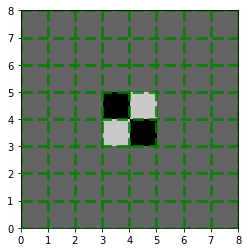


 CPUs state Input !!!!!!!!!!!!!!!!!


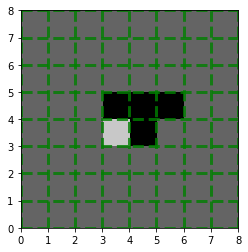

done : False

 Humans state Input !!!!!!!!!!!!!!!!!


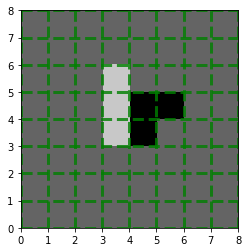


 CPUs state Input !!!!!!!!!!!!!!!!!


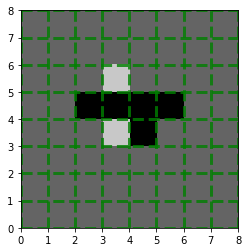

done : False

 Humans state Input !!!!!!!!!!!!!!!!!


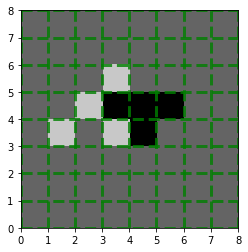


 CPUs state Input !!!!!!!!!!!!!!!!!


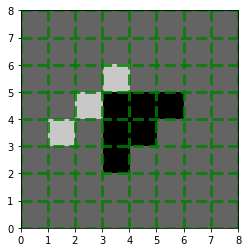

done : False

 Humans state Input !!!!!!!!!!!!!!!!!


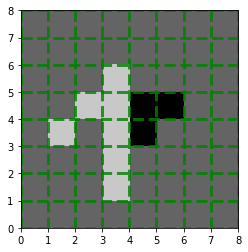


 CPUs state Input !!!!!!!!!!!!!!!!!


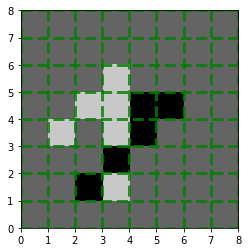

done : False

 Humans state Input !!!!!!!!!!!!!!!!!


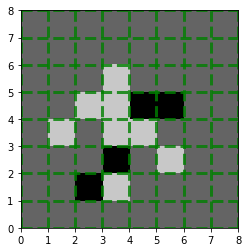


 CPUs state Input !!!!!!!!!!!!!!!!!


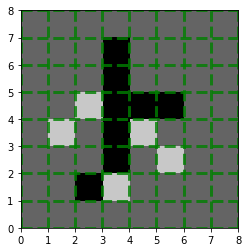

done : False

 Humans state Input !!!!!!!!!!!!!!!!!


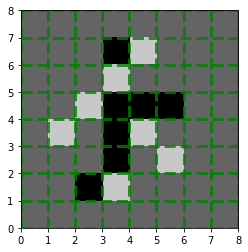


 CPUs state Input !!!!!!!!!!!!!!!!!


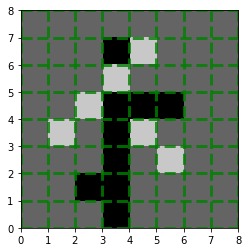

done : False

 Humans state Input !!!!!!!!!!!!!!!!!


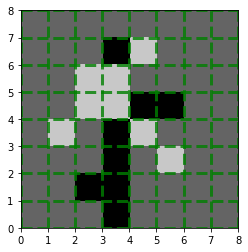


 CPUs state Input !!!!!!!!!!!!!!!!!


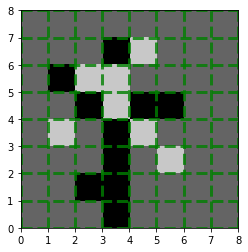

done : False

 Humans state Input !!!!!!!!!!!!!!!!!


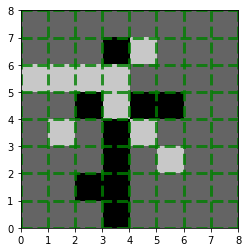


 CPUs state Input !!!!!!!!!!!!!!!!!


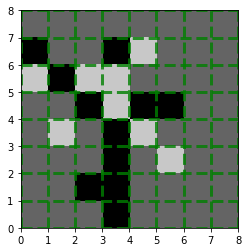

done : False

 Humans state Input !!!!!!!!!!!!!!!!!


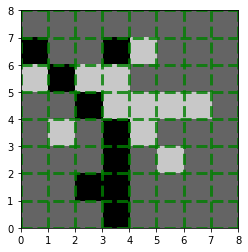


 CPUs state Input !!!!!!!!!!!!!!!!!


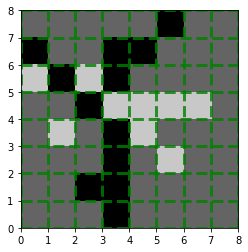

done : False

 Humans state Input !!!!!!!!!!!!!!!!!


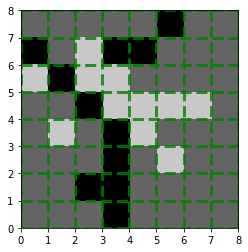


 CPUs state Input !!!!!!!!!!!!!!!!!


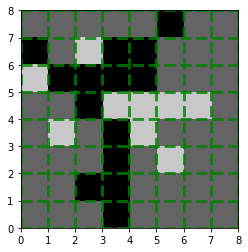

done : False

 Humans state Input !!!!!!!!!!!!!!!!!


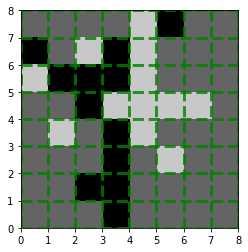


 CPUs state Input !!!!!!!!!!!!!!!!!


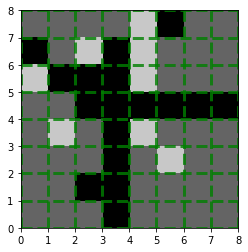

done : False

 Humans state Input !!!!!!!!!!!!!!!!!


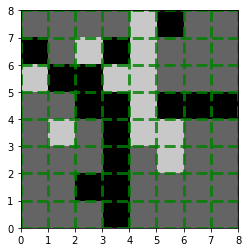


 CPUs state Input !!!!!!!!!!!!!!!!!


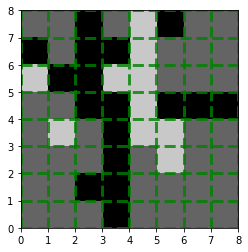

done : False

 Humans state Input !!!!!!!!!!!!!!!!!


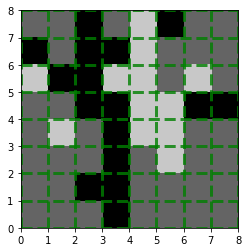


 CPUs state Input !!!!!!!!!!!!!!!!!


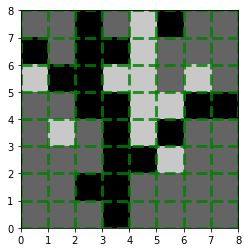

done : False

 Humans state Input !!!!!!!!!!!!!!!!!


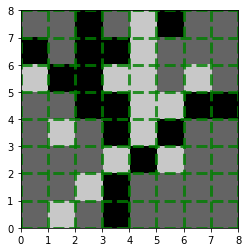


 CPUs state Input !!!!!!!!!!!!!!!!!


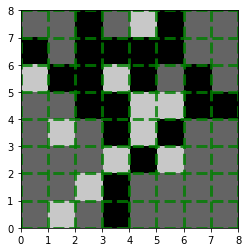

done : False

 Humans state Input !!!!!!!!!!!!!!!!!


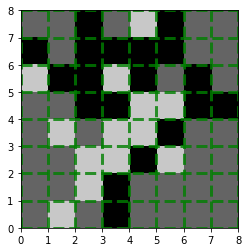


 CPUs state Input !!!!!!!!!!!!!!!!!


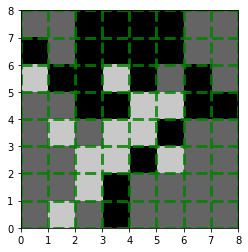

done : False

 Humans state Input !!!!!!!!!!!!!!!!!


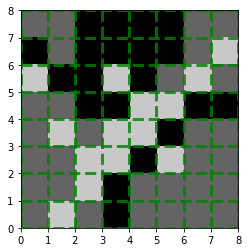


 CPUs state Input !!!!!!!!!!!!!!!!!


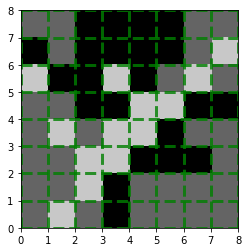

done : False

 Humans state Input !!!!!!!!!!!!!!!!!


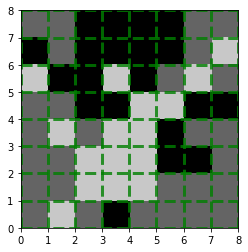


 CPUs state Input !!!!!!!!!!!!!!!!!


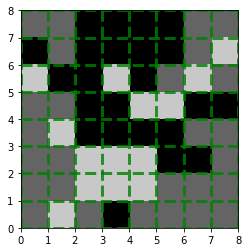

done : False

 Humans state Input !!!!!!!!!!!!!!!!!


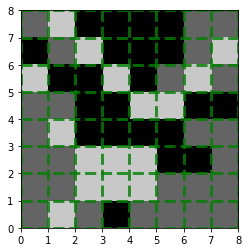


 CPUs state Input !!!!!!!!!!!!!!!!!


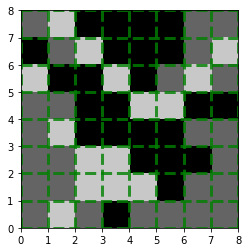

done : False

 Humans state Input !!!!!!!!!!!!!!!!!


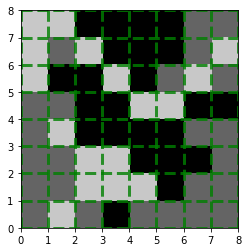


 CPUs state Input !!!!!!!!!!!!!!!!!


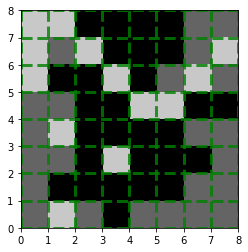

done : False

 Humans state Input !!!!!!!!!!!!!!!!!


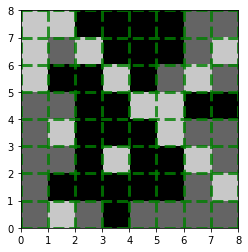


 CPUs state Input !!!!!!!!!!!!!!!!!


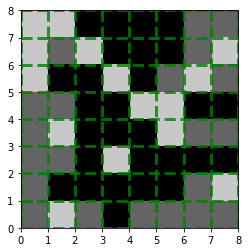

done : False

 Humans state Input !!!!!!!!!!!!!!!!!


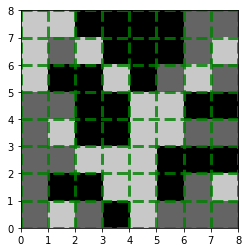


 CPUs state Input !!!!!!!!!!!!!!!!!


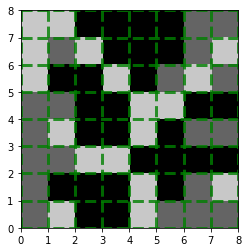

done : False

 Humans state Input !!!!!!!!!!!!!!!!!


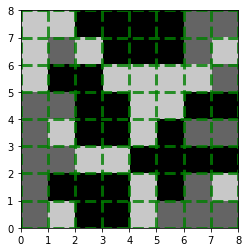


 CPUs state Input !!!!!!!!!!!!!!!!!


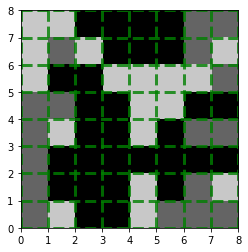

done : False

 Humans state Input !!!!!!!!!!!!!!!!!


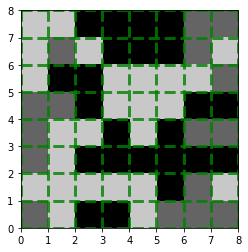


 CPUs state Input !!!!!!!!!!!!!!!!!


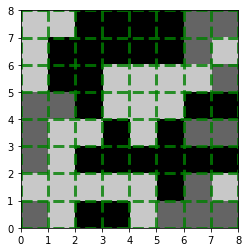

done : False

 Humans state Input !!!!!!!!!!!!!!!!!


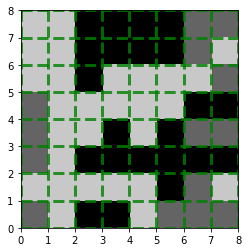


 CPUs state Input !!!!!!!!!!!!!!!!!


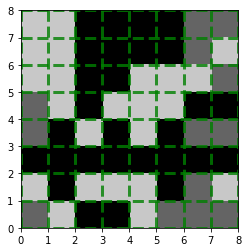

done : False

 Humans state Input !!!!!!!!!!!!!!!!!


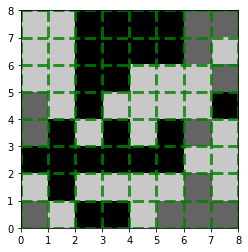


 CPUs state Input !!!!!!!!!!!!!!!!!


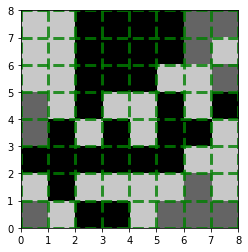

done : False

 Humans state Input !!!!!!!!!!!!!!!!!


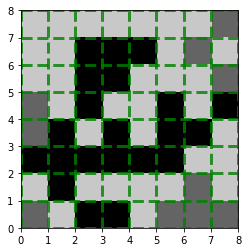


 CPUs state Input !!!!!!!!!!!!!!!!!


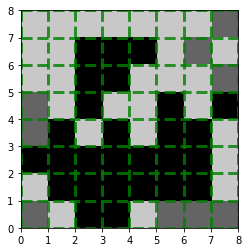

done : False

 Humans state Input !!!!!!!!!!!!!!!!!


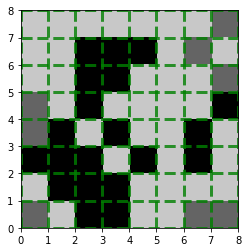


 CPUs state Input !!!!!!!!!!!!!!!!!


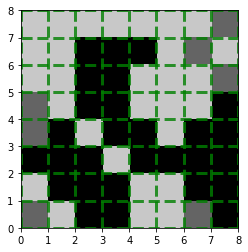

done : False

 Humans state Input !!!!!!!!!!!!!!!!!


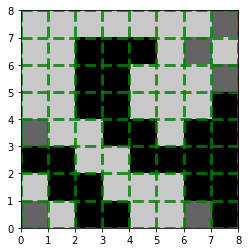


 CPUs state Input !!!!!!!!!!!!!!!!!


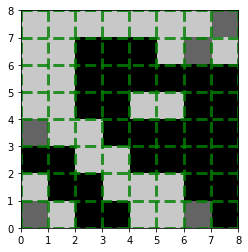

done : False

 Humans state Input !!!!!!!!!!!!!!!!!


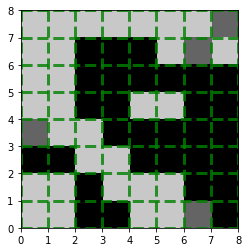


 CPUs state Input !!!!!!!!!!!!!!!!!


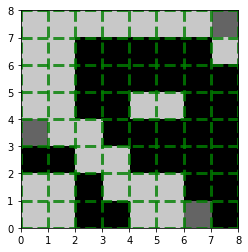

done : False

 Humans state Input !!!!!!!!!!!!!!!!!


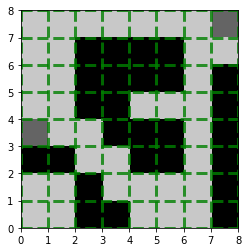

done : False

 Humans state Input !!!!!!!!!!!!!!!!!


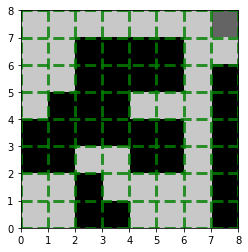

done : True

 最終盤面


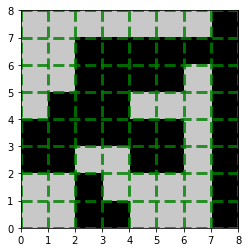

episode : 0
31


In [7]:
GAMMA = 0.99
CAPACITY = 10000
BATCH_SIZE = 32
MAX_ITER = 0

AAA = Environment()
TTT = AAA.train()